## Score function

In [1]:
import requests
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import io

from dotenv import load_dotenv

load_dotenv()

LOCALHOST = os.getenv("LOCALHOST")

# RTSP stream URL
rtsp_url = f'rtmp://{LOCALHOST}:1935/live/stream'

# Define the service URL
LOCAL_ENDPOINT = f"http://{LOCALHOST}:5001/image"

# Define headers
headers = {'Content-Type': 'application/octet-stream'}

# Define threshold
THRESHOLD = 0.3  # Adjust this value as needed

# Define colors for bounding boxes
colours = {'Coffee cup':  (0, 255, 0),}

def predict(img):
    is_success, im_buf_arr = cv2.imencode(".jpg", img)
    byte_im = im_buf_arr.tobytes()
    
    # Call the API to get predictions
    response = requests.post(LOCAL_ENDPOINT, headers=headers, data=byte_im)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to get a response from the service: {response.status_code}")
        return None

def combine(image, results, threshold=THRESHOLD):
    # Read the image using cv2
    height, width, _ = image.shape

    for prediction in results['predictions']:
        if prediction['probability'] >= THRESHOLD:
            colour = colours[prediction['tagName']]
            tag = f"{prediction['tagName']} {prediction['probability']*100:.2f}%"

            l_p = round(prediction['boundingBox']['left'] * width)
            w_p = round(prediction['boundingBox']['width'] * width)
            t_p = round(prediction['boundingBox']['top'] * height)
            h_p = round(prediction['boundingBox']['height'] * height)

            # Draw the bounding box
            cv2.rectangle(image, (l_p, t_p), (l_p + w_p, t_p + h_p), colour, 2)
            # Put the label above the bounding box
            cv2.putText(image, tag, (l_p, t_p - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, colour, 1, cv2.LINE_AA)

    return image


def score(image, threshold=THRESHOLD):
    # Run local prediction
    results = predict(image)
    
    # Combine image with results
    if results:
        combined_image = combine(image, results, threshold)
        return combined_image
    else:
        print("No results to display.")
        return None

## Scoring static images

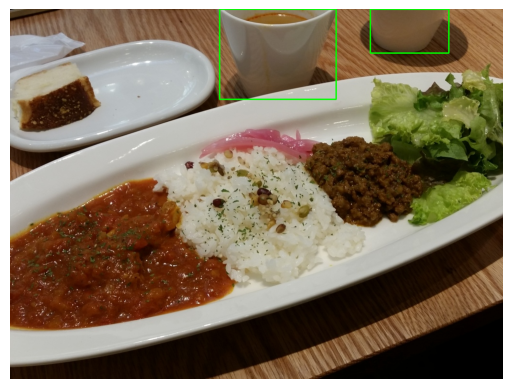

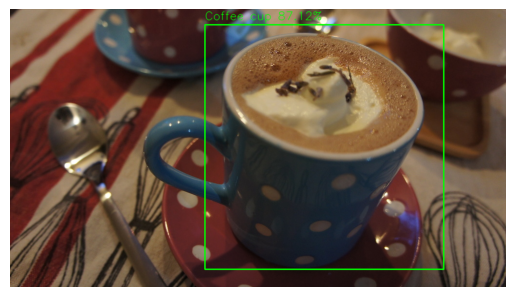

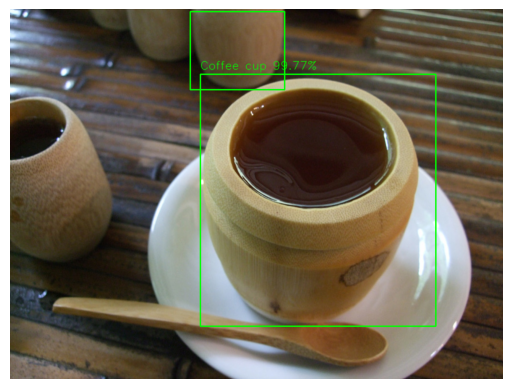

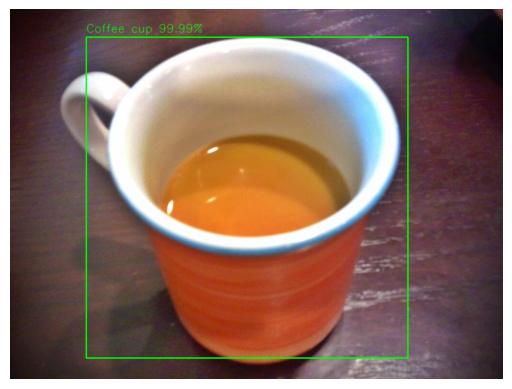

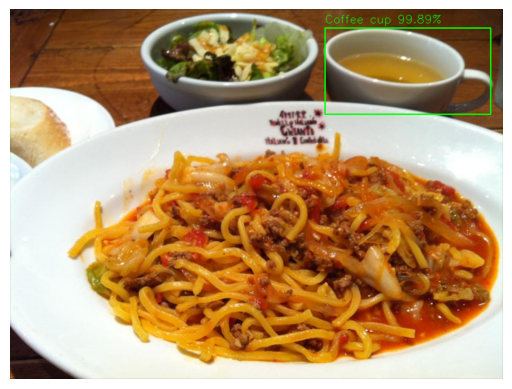

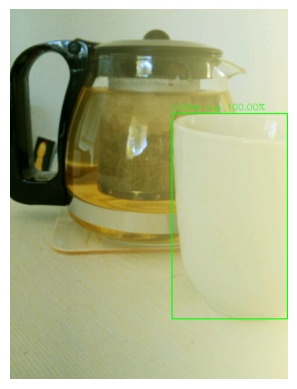

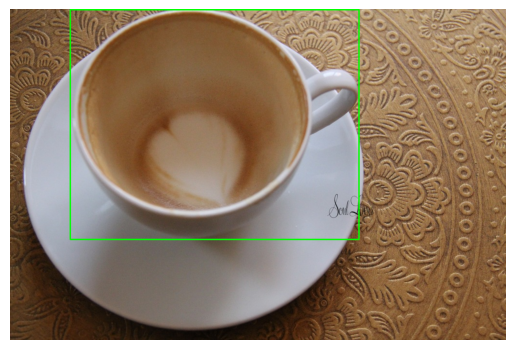

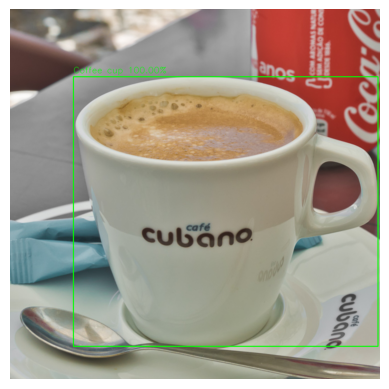

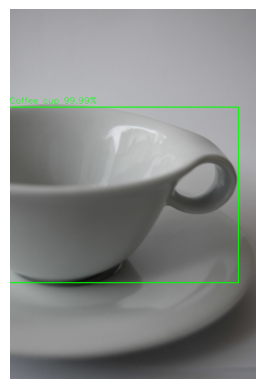

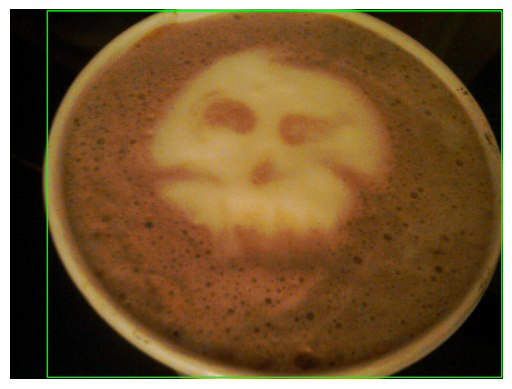

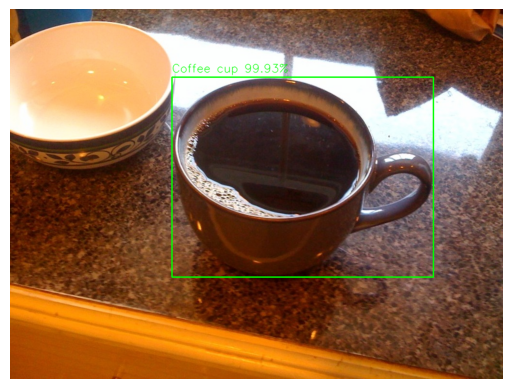

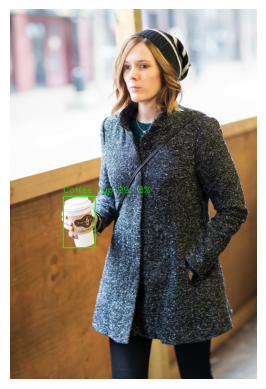

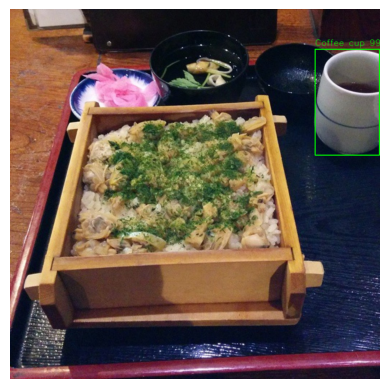

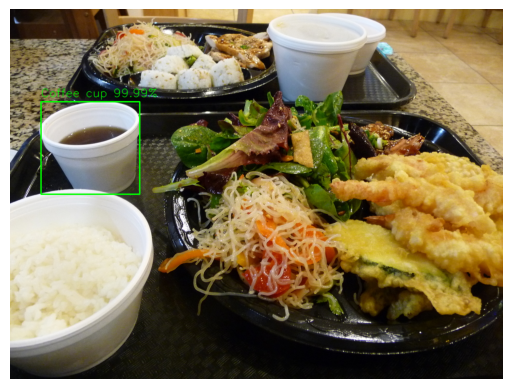

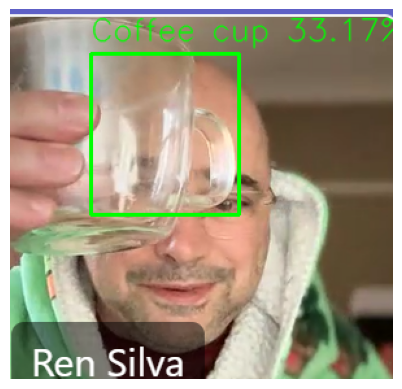

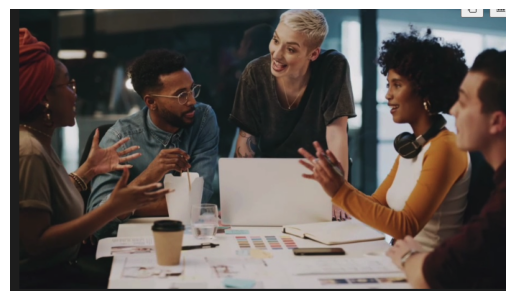

In [4]:
import glob

# Path to the image
image_path = 'pic.png'
# Path to the images
image_paths = glob.glob('./data/*')

for image_path in image_paths:
    img = cv2.imread(image_path)
    combined_image = score(img, threshold=0.001)
    
    plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

